# NEST Benchmark Plots
Author: Sophia Andaloro
<br>
Date: July 6, 2020
<br>
Notebook purpose: Make plots used in the website. 
<br>
These are made in `main.py` but please look at the repo to see how these are made in practice on the repo: https://github.com/NESTCollaboration/benchmark_plots 

In [22]:
import collections
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nestpy

In [23]:
print("NEST Version: v", nestpy.__nest_version__)
print("nestpy Version: v", nestpy.__version__)

NEST Version: v 2.1.0
nestpy Version: v 1.3.0


In [24]:
import benchmark_plots as bp # Functions to make nice plots (and debug them here as versions get updated)
import interaction_keys # Makes calling often-used interaction types much simpler

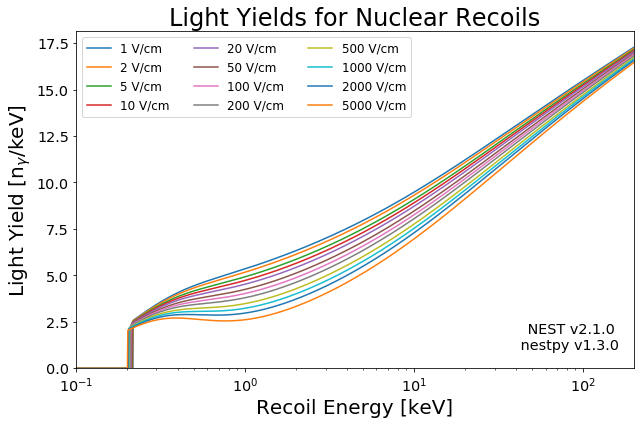

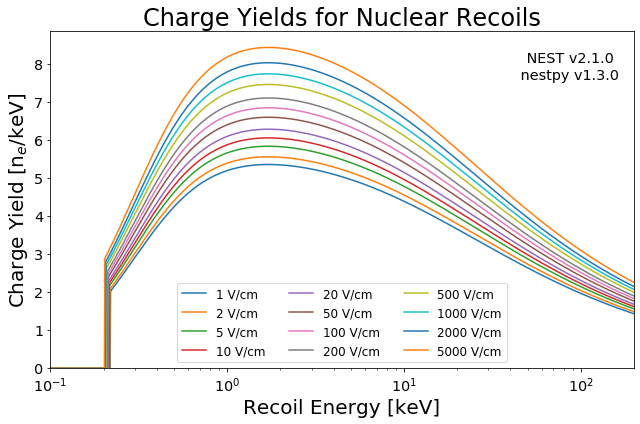

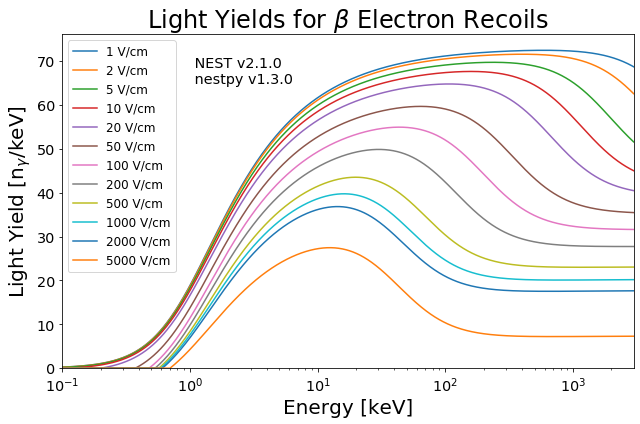

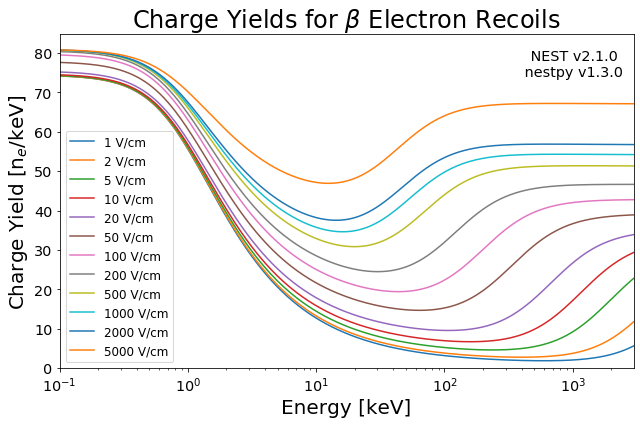

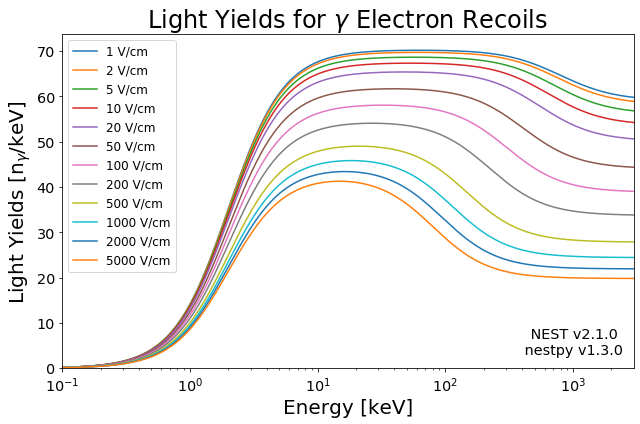

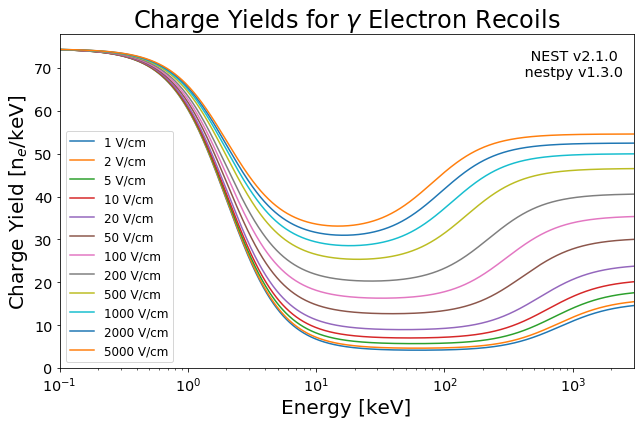

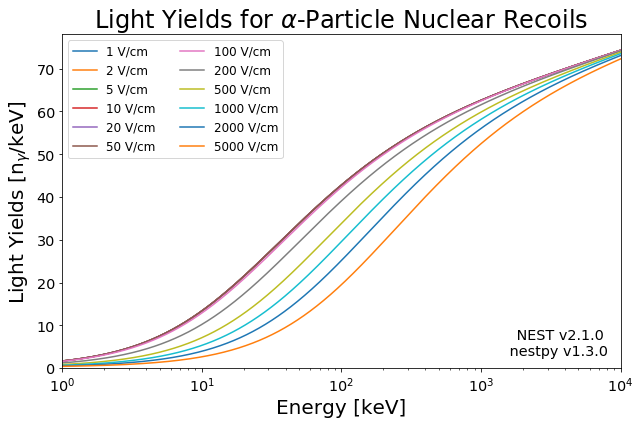

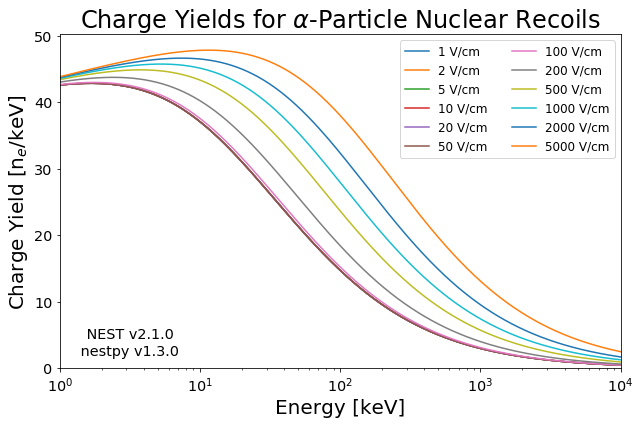

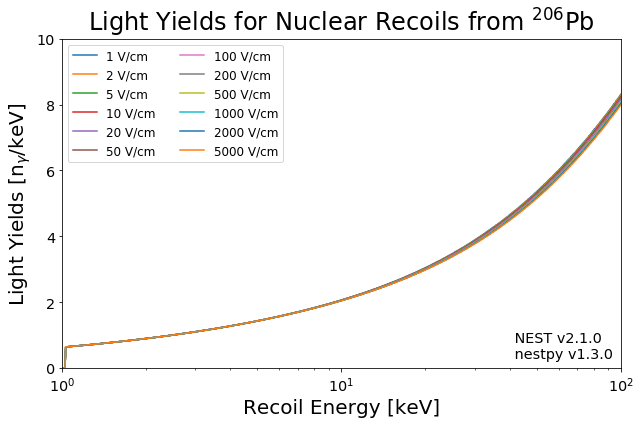

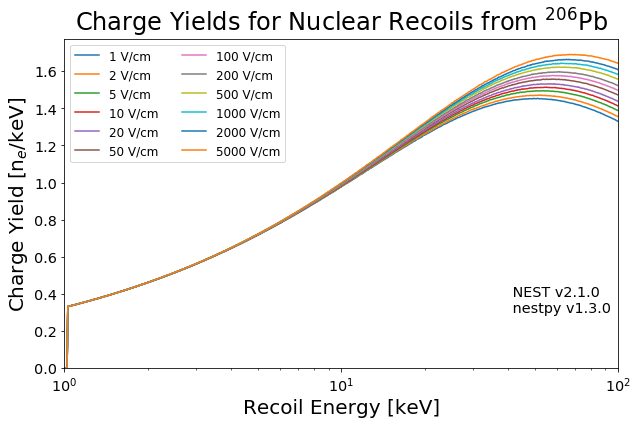

In [25]:
IMAGE_OBJECTS = collections.defaultdict(io.BytesIO)
bp.makeplots(IMAGE_OBJECTS)

Save images

In [26]:
for key in IMAGE_OBJECTS.keys():
    with open(key, 'wb') as f:
        f.write(IMAGE_OBJECTS[key].getbuffer())

In [27]:
version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')

## Making Kr and other custom plots

In [7]:
@np.vectorize
def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    # returns the yields for the type of yield we are considering 
    return getattr(yield_object, yield_type)

def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
 
def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

In [8]:
#Detector identification
detector = nestpy.DetectorExample_XENON10()
# detector = nestpy.VDetector()
# Performing NEST calculations according to the given detector example       
nc = nestpy.NESTcalc(detector) #can also be left empty    

#GetInteractionObject grabs the number for the interaction you want so you don't have to always reference the dictionary. Just type e.g., 'ion'
#It just changes the name to a number for nestpy to do its work.

In [9]:
fields=np.linspace(0, 2000, 1000)
energies = np.asarray([32.1, 41.5])
energies = np.reshape(energies, (2,1))
energies = np.broadcast_to(energies, (len(energies), len(fields)))

kwargs = {'energy': energies, 'drift_field': fields}
kr_qy = ElectronYield(interaction=nestpy.nestpy.INTERACTION_TYPE.Kr83m, **kwargs)/energies #yields/keV
kr_ly = PhotonYield(interaction=nestpy.nestpy.INTERACTION_TYPE.Kr83m, **kwargs)/energies #yields/keV

Yikes... we see there's a new time-dependence that nestpy has not wrapped to NEST, there are no science issues, but for plotting, we'll want to get creative. 

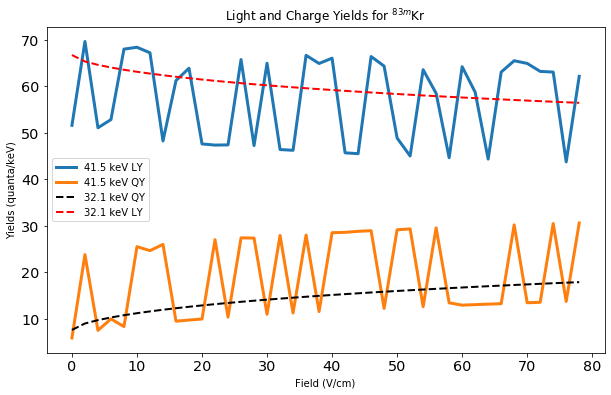

In [11]:
plt.figure(figsize=(10,6))

plt.plot(fields[:40], kr_ly[1][:40],linewidth=3,  label='41.5 keV LY')
plt.plot(fields[:40], kr_qy[1][:40],linewidth=3, label='41.5 keV QY')
plt.plot(fields[:40], kr_qy[0][:40], 'k--', linewidth=2, label='32.1 keV QY')
plt.plot(fields[:40], kr_ly[0][:40], 'r--', linewidth=2, label='32.1 keV LY')
plt.xlabel('Field (V/cm)')
plt.ylabel('Yields (quanta/keV)')
plt.legend(loc='best')
plt.title('Light and Charge Yields for $^{83m}$Kr')
# plt.text(1500, 10, version_textbox, bbox = bbox)
# plt.ylim((40, 50))
# plt.xscale('log')
plt.show()

Let's make our own Kr83m model in python since it won't wrap nice and easy.

## Making my own Kr Model 
Based on the cpp code

In [12]:
density=2.9
xi_se = 9./(1.+pow(density/2.,2.))
alpha = 0.067366 + density * 0.039693
I_ion = 9.+(12.13-9.)/(1.+pow(density/2.953,65.))
I_exc = I_ion / 1.46
Wq_eV = I_exc*(alpha/(1.+alpha))+I_ion/(1.+alpha)+xi_se/(1.+alpha)
deltaT_ns_halflife = 154.4
# eDensity = (density/fdetector->get_molarMass())*NEST_AVO*ATOM_NUM

### Kr yields model

In [13]:
def GetYieldKr83m(energy=9.4, density=2.9, dfield=124., maxTimeSeparation=151, deltaT_ns=-999):
    Nq = -999
    Nph = -999
    Ne = -999
    
#     Wq_eV = 13.7 
    alpha = 0.067366 + density * 0.039693
    
    #total yields. easy 
    Nq = energy * 1e3 / Wq_eV
    
    #If a time-dependent energy emission 
    if np.isin(energy, [9.4, 41.5]):
        while deltaT_ns <0:
            deltaT_ns = np.random.exponential(deltaT_ns_halflife/np.log(2))
        medTlevel = 57.462 + (69.201 - 57.462 ) / pow(1. + pow(dfield / 250.13, 0.9), 1.)
        lowTdrop = 35. + (75. - 35.) / pow(1. + pow(dfield/60, 1), 1)
        lowTpeak = 6.2831e4 - (6.2831e4 - 5.949e4 ) / pow(1. + pow(dfield/60, 1.), 1)
        Nph = 9.4 * (lowTpeak * pow(2. * deltaT_ns + 10., -1.5) + medTlevel) / (1. + pow(deltaT_ns / lowTdrop, -1.*lowTdrop/5.))
        Nq = 9.4 * 1e3 / Wq_eV
        Ne = Nq - Nph
        
        if energy==41.5: #41.5 changes model 
            Nph_32 = 32.1 * (6. + (66.742 - 6.) / pow(1. + pow(dfield / 115.037,  0.6409),0.3215))
            Ne_32 = ( 32.1 * 1e3 / Wq_eV ) - Nph_32
            Nph += Nph_32
            Ne  += Ne_32
    elif energy==32.1:
        Nq = energy * 1e3 / Wq_eV
        Nph = energy * (6. + (66.742 - 6.) / pow(1. + pow(dfield / 115.037,  0.6409),0.3215))
        Ne = Nq - Nph
    if Ne<0:
        Ne=0
    return Ne, Nph

In [15]:
dts = np.random.exponential(deltaT_ns_halflife/np.log(2), size=1000000)
mean_time = np.mean(dts)
max_time = 1000
min_time = 150

In [16]:
def GetDist(energy=41.5, dfield=124, **kwargs):
    qy, ly = GetYieldKr83m(energy=energy, density=2.9, dfield=dfield, **kwargs)
    qy = qy/energy
    ly = ly/energy
    return ly, qy 

In [17]:
def GetAvgs(n_samples=200,**kwargs):
    yields = np.zeros((n_samples,2))
    for i in range (n_samples):
        yields[i,0], yields[i,1] = GetDist(**kwargs)
    avg_yields = np.mean(yields, axis=0)
    return avg_yields

### Field-dependent Yields

In [18]:
num_samples = 1000
DriftFields = np.linspace(0., 2000., 1001)
LY = np.zeros((DriftFields.shape[0], 7))
QY = np.zeros_like(LY)

for i, field in enumerate(DriftFields):
    LY[i,0], QY[i,0] = GetDist(deltaT_ns=mean_time, dfield=field)
    LY[i,1], QY[i,1] = GetDist(deltaT_ns=min_time, dfield=field)
    LY[i,2], QY[i,2] = GetDist(deltaT_ns=max_time, dfield=field)
    LY[i,3], QY[i,3] = GetDist(energy=32.1, dfield=field)
    LY[i,4], QY[i,4] = GetDist(energy=9.4, deltaT_ns=mean_time, dfield=field)
    LY[i,5], QY[i,5] = GetDist(energy=9.4, deltaT_ns=min_time, dfield=field)
    LY[i,6], QY[i,6] = GetDist(energy=9.4, deltaT_ns=max_time, dfield=field)


In [19]:
labels = ['41.5 keV LY',
          '41.5 keV QY',
          '32.1 keV LY',
          '32.1 keV QY',    
          '9.4 keV LY',
          '9.4 keV QY',
]
colors = ['r',
          'cornflowerblue',
          'c',
          'green',
          'darkviolet',
          'orange',
]

In [20]:
mean_time

223.01037135115774

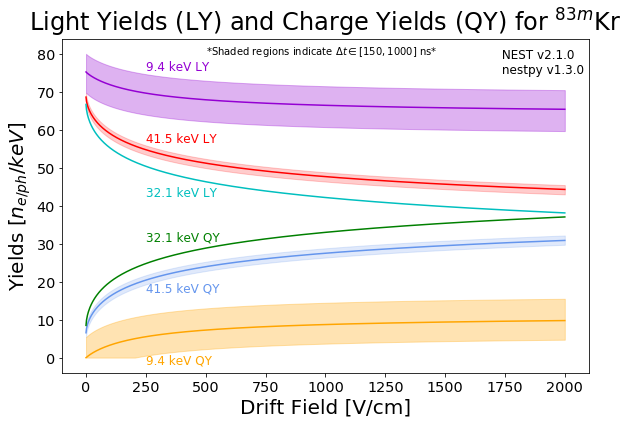

In [30]:
plt.figure(figsize=(9,6))
#plot 41.5 keV yields
plt.plot(DriftFields, LY[:,0], c=colors[0], label=r'Light yields for $^{83m}$Kr (41.5 keV)')
plt.plot(DriftFields, QY[:,0], c=colors[1], label=r'Charge yields for $^{83m}$Kr (41.5 keV)')
plt.fill_between(DriftFields, QY[:,1], QY[:,2], color=colors[1],alpha=0.2)
plt.fill_between(DriftFields, LY[:,1], LY[:,2], color=colors[0],alpha=0.2)
plt.annotate(labels[0], xy = (250, LY[:,0][DriftFields==250.]+2), 
             color=colors[0], fontsize=12)
plt.annotate(labels[1], xy = (250, QY[:,0][DriftFields==250.]-3), 
             color=colors[1], fontsize=12)
#plot 32.1 keV 
plt.plot(DriftFields, LY[:,3], c=colors[2], label=r'Light yields for $^{83m}$Kr (32.1 keV)')
plt.plot(DriftFields, QY[:,3], c=colors[3], label=r'Charge yields for $^{83m}$Kr (32.1 keV)')
plt.annotate(labels[2], xy = (250, LY[:,3][DriftFields==250.]-8), 
             color=colors[2], fontsize=12)
plt.annotate(labels[3], xy = (250, QY[:,3][DriftFields==250.]+6), 
             color=colors[3], fontsize=12)
#plot 9.4 keV 
plt.plot(DriftFields, LY[:,4], c=colors[4], label=r'Light yields for $^{83m}$Kr (9.4 keV)')
plt.fill_between(DriftFields, LY[:,5], LY[:,6], color=colors[4],alpha=0.3)
plt.plot(DriftFields, QY[:,4], c=colors[5], label=r'Charge yields for $^{83m}$Kr (9.4 keV)')
plt.fill_between(DriftFields, QY[:,5], QY[:,6], color=colors[5],alpha=0.3)
plt.annotate(labels[4], xy = (250, LY[:,5][DriftFields==250.]+1), 
             color=colors[4], fontsize=12)
plt.annotate(labels[5], xy = (250, QY[:,5][DriftFields==250.]-2), 
             color=colors[5], fontsize=12)
# Labeling 
# lg = plt.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', fontsize=12)

# Formatting
# plt.legend(loc='best',fontsize=12, ncol=3)
plt.title(r'Light Yields (LY) and Charge Yields (QY) for $^{83m}$Kr', fontsize=24)
plt.xlabel(r'Drift Field [V/cm]', fontsize=20)
plt.ylabel(r'Yields [$n_{e/ph}/keV$]', fontsize=20)
plt.tight_layout()
plt.annotate(version_textbox,(1720,75),
            fontsize=12)
plt.annotate(r'*Shaded regions indicate $\Delta t \in [150, 1000]$ ns*', (500, 80))

# plt.margins(0)
plt.savefig('kr83m_yields.png')
plt.show()# bbox_extra_artists=(lg,), 
           # bbox_inches='tight')

### Time-dependent Light & Charge yields

In [31]:
@np.vectorize
def getyields(**kwargs):
    return GetDist(**kwargs) # (energy=9.4, density=2.9, dfield=124., maxTimeSeparation=151, deltaT_ns=-999)

In [44]:
times = np.logspace(0., 4., 1001)
fields =np.asarray([1, 5, 10, 50, 100, 200, 500, 1000, 2000])  # np.logspace(0., 4., 101) # use for meshing 
LY = np.zeros((times.shape[0], fields.shape[0])).T
QY = np.zeros_like(LY)
for i, field in enumerate(fields):
    LY[i], QY[i] = getyields(energy=9.4, deltaT_ns=times, dfield=field)

In [63]:
n = fields.shape[0]
colors = pl.cm.jet(np.linspace(0,1,n+1)) #plasma ? 

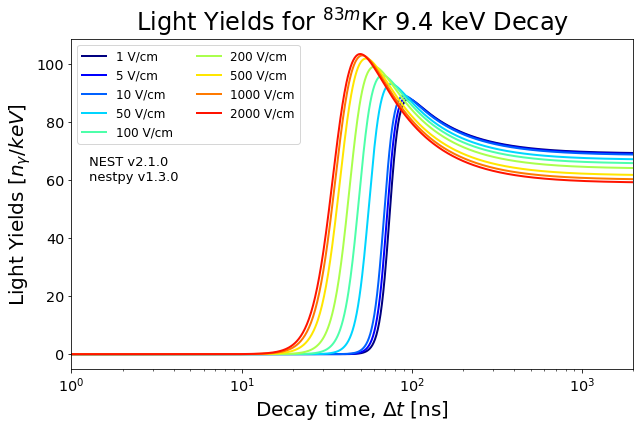

In [70]:
plt.figure(figsize=(9,6))
for i, field in enumerate(fields):
#     plt.plot(times, LY[i], color='r' if field==100 else colors[i], linewidth=3, label=str(field)+' V/cm' if np.isin(field, [1, 100, 2000]) else None)
    plt.plot(times, LY[i], color=colors[i],linewidth=2, label=str(field)+' V/cm')
# Labeling 
# lg = plt.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', fontsize=12)

# Formatting
plt.legend(loc='upper left',fontsize=12, ncol=2)
plt.title(r'Light Yields for $^{83m}$Kr 9.4 keV Decay', fontsize=24)
plt.xlabel(r'Decay time, $\Delta t$ [ns]', fontsize=20)
plt.ylabel(r'Light Yields [$n_{\gamma}/keV$]', fontsize=20)
plt.tight_layout()
plt.annotate(version_textbox,(1.2,60),
            fontsize=13)
# plt.colorbar(pl.cm.ScalarMappable(cmap = pl.cm.plasma))
# plt.annotate(r'*Shaded regions indicate $\Delta t \in [150, 1000]$ ns*', (500, 80))
plt.xlim((1, 2e3))
plt.xscale('log')

plt.savefig('94kr83m_LY.png')

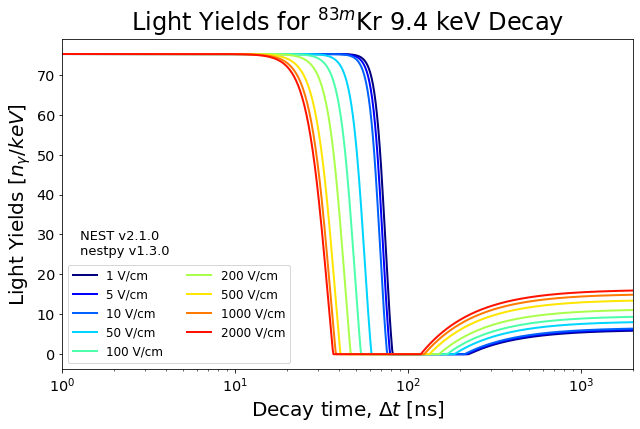

In [71]:
plt.figure(figsize=(9,6))
for i, field in enumerate(fields):
#     plt.plot(times, LY[i], color='r' if field==100 else colors[i], linewidth=3, label=str(field)+' V/cm' if np.isin(field, [1, 100, 2000]) else None)
    plt.plot(times, QY[i], color=colors[i],linewidth=2, label=str(field)+' V/cm')
# Labeling 
# lg = plt.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', fontsize=12)

# Formatting
plt.legend(loc='lower left',fontsize=12, ncol=2)
plt.title(r'Light Yields for $^{83m}$Kr 9.4 keV Decay', fontsize=24)
plt.xlabel(r'Decay time, $\Delta t$ [ns]', fontsize=20)
plt.ylabel(r'Light Yields [$n_{\gamma}/keV$]', fontsize=20)
plt.tight_layout()
plt.annotate(version_textbox,(1.2,25),
            fontsize=13)
# plt.colorbar(pl.cm.ScalarMappable(cmap = pl.cm.plasma))
# plt.annotate(r'*Shaded regions indicate $\Delta t \in [150, 1000]$ ns*', (500, 80))
plt.xlim((1, 2e3))
plt.xscale('log')
plt.savefig('94kr83m_QY.png')

## Heavy Nuclei Yields
Skipping a beat, let's go into heavy nuclei (ion) yields. 
These are new for me as of this nb so bear with the learning experience

Let's recreate the Pb ion yields first, for 1 GeV, whatever that means and we'll know we're on the right track

In [165]:
A_list = [1, #1H
          12, # 12C
          20, #20Ne
          28, #28Si
          39, #39Ar
          56, #56Fe
          206, #206Pb
          252, #252Cf
         ]

Z_list = [1,
          6, 
          10, 
          14, 
          18,
          26,
          82, 
          98
         ]

Name_list = ['$^1$H', 
            '$^{12}$C', 
            '$^{20}$Ne', 
            '$^{28}$Si', 
            '$^{39}$Ar', 
            '$^{56}$Fe', 
            '$^{206}$Pb', 
            '$^{252}$Cf', 
            ]

In [120]:
energy = 1e6 # in keV, so 1 GeV total (really energetic)
fields = np.linspace(0,5000,1000)
ion_LY = np.zeros((len(Z_list), fields.shape[0]))
ion_QY = np.zeros_like(ion_LY)
for i, (A, Z) in enumerate(zip(A_list, Z_list)):
    ion_LY[i] = bp.PhotonYield(interaction='ion',Z=Z, A = A, energy=energy, drift_field=fields)/energy
    ion_QY[i] = bp.ElectronYield(interaction='ion',Z=Z, A = A, energy=energy, drift_field=fields)/energy

/home/sophiaandaloro/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/sophiaandaloro/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


### Let's plot

In [144]:
n = len(Z_list)
colors = pl.cm.nipy_spectral(np.linspace(0,1,n)) #plasma ? gnuplot?

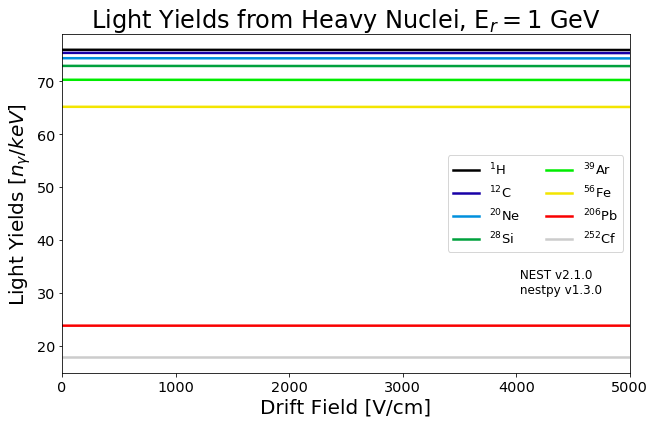

In [181]:
plt.figure(figsize=(9,6))
for i, (A, Z) in enumerate(zip(A_list, Z_list)):
    plt.plot(fields, ion_LY[i], linewidth=2.5, color=colors[i], label=Name_list[i])
# plt.vlines(100, 0, 0.05, colors='purple', linestyles='dashed', label='100 V/cm')
# plt.xscale('log')
# Formatting
plt.legend(loc='center right',fontsize=13, ncol=2)
plt.title(r'Light Yields from Heavy Nuclei, E$_{r} = 1$ GeV', fontsize=24)
plt.xlabel(r'Drift Field [V/cm]', fontsize=20)
plt.ylabel(r'Light Yields [$n_{\gamma}/keV$]', fontsize=20)
plt.tight_layout()
plt.annotate(version_textbox,(4000,30),
            fontsize=12)
plt.margins(x=0)
plt.savefig('heavyion_LY.png')

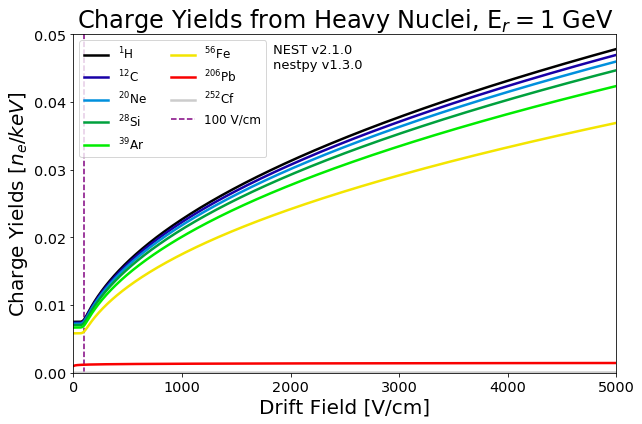

In [182]:
plt.figure(figsize=(9,6))
for i, (A, Z) in enumerate(zip(A_list, Z_list)):
    plt.plot(fields, ion_QY[i], linewidth=2.5, color=colors[i], label=Name_list[i])
plt.vlines(100, 0, 0.05, colors='purple', linestyles='dashed', label='100 V/cm')
# plt.xscale('log')
# Formatting
plt.legend(loc='upper left',fontsize=12, ncol=2)
plt.title(r'Charge Yields from Heavy Nuclei, E$_{r} = 1$ GeV', fontsize=24)
plt.xlabel(r'Drift Field [V/cm]', fontsize=20)
plt.ylabel(r'Charge Yields [$n_{e}/keV$]', fontsize=20)
plt.tight_layout()
plt.annotate(version_textbox,(1800,.045),
            fontsize=13)
plt.margins(0)
plt.savefig('heavyion_QY.png')